# Explore here

In [163]:
import pandas as pd
from utils import db_connect
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy import stats

In [164]:
# Establecer la conexión a la base de datos
engine = db_connect()

# Verificar si la conexión es exitosa
#if engine:
    #print("Conexión exitosa")

# Consultar la tabla en la base de datos y crear un DataFrame
data = pd.read_sql_table('tabla seguro', engine)

pd.set_option('display.max_columns', None)  # muestra todas las columnas del dataframe
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [165]:
data.shape

(1338, 7)

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [167]:
data.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [168]:
data.isnull().any().any()

False

In [169]:
data.duplicated().sum()
fila_duplicada = data[data.duplicated()]
fila_duplicada

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [170]:
data = data.drop_duplicates().reset_index(drop = True)
data.duplicated().sum()

0

In [171]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [172]:
# Usamos pd.factorize para codificar las columnas para preservar el orden de las categorias, 
# a diferencia de LabelEncoder, que usa menos memoria pero no mantiene el orden de las categorias.

# Nos decidimos por esta forma ya que tenemos pocas categorías distintas, y pd.factorize
# devuelve tanto los códigos numéricos como las categorías originales, lo que puede ser útil para futuros análisis.

data["sex_num"] = pd.factorize(data["sex"])[0]
data["smoker_num"] = pd.factorize(data["smoker"])[0]
data["region_num"] = pd.factorize(data["region"])[0]

data.head()



,age,sex,bmi,children,smoker,region,charges,sex_num,smoker_num,region_num
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1,2


In [173]:
data_num = data[["age", "bmi", "children", "sex_num", "smoker_num", "region_num", "charges"]].copy() # .copy() para crear dataframe independiente al original
data_num.corr()

# Vemos que apenas hay correlacion entre la región y la prima de seguro, algo normal,
#  * ya que si bien una region puede tener una tendencia hacia una característica influyente mayor que la otra, no tiene que verse reflejada
#  * en todos los sujetos de dicha zona, por lo que sería injusto que, por ejemplo, su prima aumentase por proceder de una zona con mayor 
#  * índice de fumadores, a pesar de que el sujeto concreto no haya fumado en su vida.
# Lo mismo ocurre en relación al sexo.

# Por tanto, eliminaremos las variables.

,age,bmi,children,sex_num,smoker_num,region_num,charges
age,1.000000,0.109344,0.041536,-0.019814,0.025587,-0.001626,0.298308
bmi,0.109344,1.000000,0.012755,0.046397,-0.003746,-0.157574,0.198401
children,0.041536,0.012755,1.000000,0.017848,-0.007331,-0.016258,0.067389
sex_num,-0.019814,0.046397,0.017848,1.000000,-0.076596,-0.004936,0.058044
smoker_num,0.025587,-0.003746,-0.007331,-0.076596,1.000000,-0.002358,-0.787234
region_num,-0.001626,-0.157574,-0.016258,-0.004936,-0.002358,1.000000,0.006547
charges,0.298308,0.198401,0.067389,0.058044,-0.787234,0.006547,1.000000


Edad y Costos: Hay una correlación positiva moderada entre la edad y los costos médicos. Esto sugiere que a medida que la edad aumenta, es probable que los costos médicos también aumenten, lo cual es razonable ya que las personas mayores tienden a tener más problemas de salud y pueden requerir más atención médica.

IMC (BMI) y Costos: Existe una correlación positiva leve entre el índice de masa corporal (IMC) y los costos médicos. Esto indica que las personas con un IMC más alto tienden a tener costos médicos ligeramente más altos. Sin embargo, la correlación no es muy fuerte.

Fumadores y Costos: La correlación entre el hecho de ser fumador y los costos médicos es bastante alta y negativa. Esto sugiere que los fumadores tienden a tener costos médicos mucho más altos en comparación con los no fumadores. Esta es una observación significativa y coherente con la literatura médica, ya que el hábito de fumar está asociado con una variedad de problemas de salud.

Región y Costos: La correlación entre la región y los costos médicos es muy baja, lo que indica que la región donde reside una persona tiene una influencia mínima en sus costos médicos.

Sexo y Costos: La correlación entre el sexo y los costos médicos es muy baja, lo que indica que no hay una relación significativa entre el sexo de una persona y sus costos médicos.

En resumen, la edad, el IMC y el hábito de fumar parecen ser los factores más influyentes en los costos médicos, según esta matriz de correlación.

In [174]:
data.drop(['region', 'region_num', 'sex', 'sex_num'], axis=1, inplace=True)
data_num.drop(['region_num', 'sex_num'], axis=1, inplace=True)
data.head()

,age,bmi,children,smoker,charges,smoker_num
0,19,27.900,0,yes,16884.92400,0
1,18,33.770,1,no,1725.55230,1
2,28,33.000,3,no,4449.46200,1
3,33,22.705,0,no,21984.47061,1
4,32,28.880,0,no,3866.85520,1


In [175]:
#  Buscar valores atípicos (y ver si corresponderia tambien consultar la influencia), antes de elegir el método de escalado

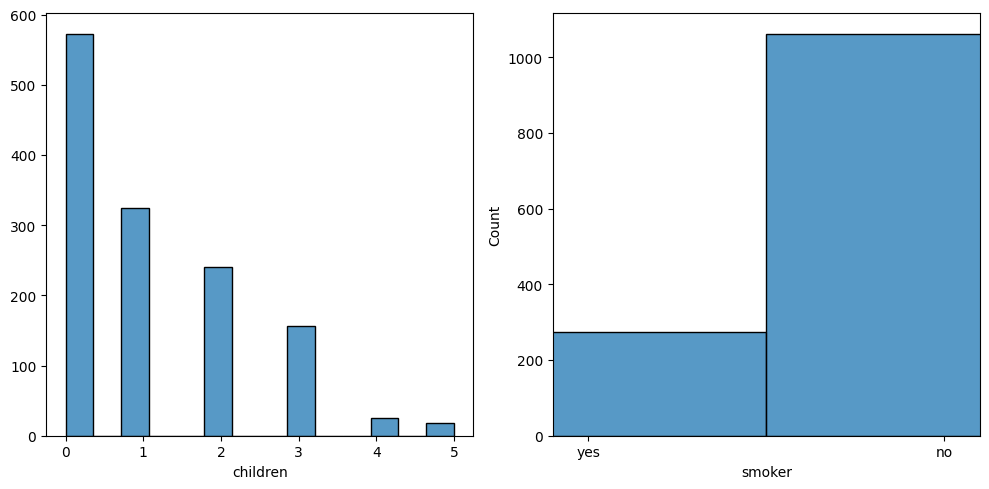

In [176]:
# Análisis ded variables univariantes (categóricas)

fig, axis = plt.subplots(1, 2, figsize = (10, 5))

# Crear un histograma múltiple
sns.histplot(ax = axis[0], data = data, x = "children").set(ylabel = None)
sns.histplot(ax = axis[1], data = data, x = "smoker").set_xlim(-0.1, 1.1)


# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

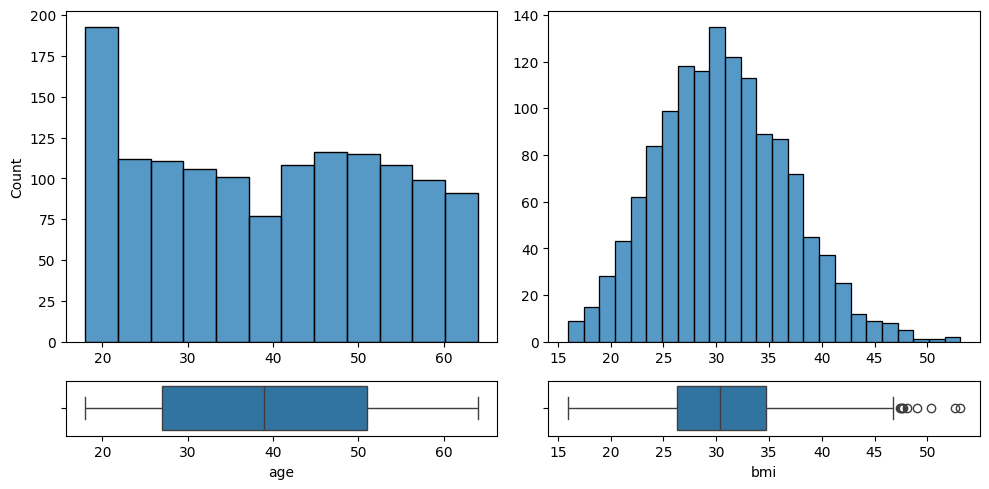

In [177]:
# Análisis sobre variables numéricas

fig, axis = plt.subplots(2, 2, figsize = (10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0, 0], data = data, x = "age").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = data, x = "age")
sns.histplot(ax = axis[0, 1], data = data, x = "bmi").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = data, x = "bmi")

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

<Axes: xlabel='charges'>

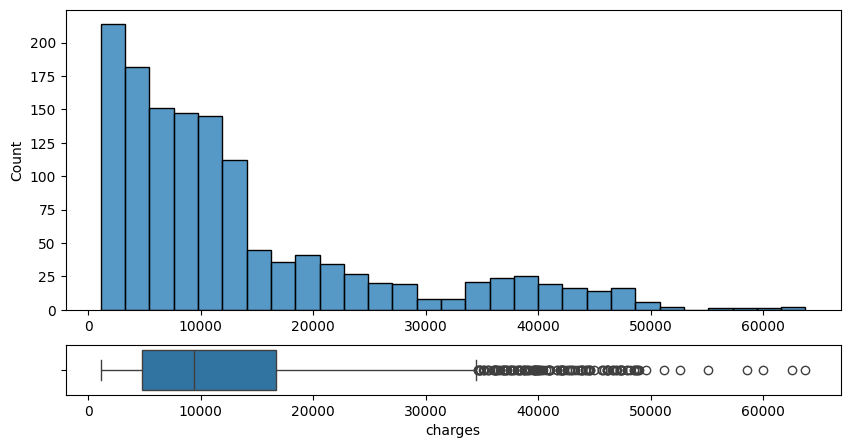

In [178]:
fig, axis = plt.subplots(2, 1, figsize = (10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0], data = data, x = "charges").set(xlabel = None)
sns.boxplot(ax = axis[1], data = data, x = "charges")

<Axes: xlabel='charges_log'>

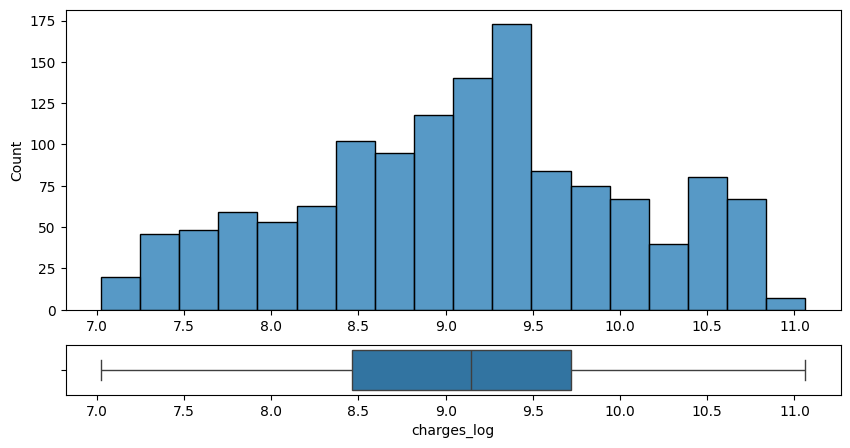

In [179]:
data['charges_log'] = np.log(data.charges)

fig, axis = plt.subplots(2, 1, figsize = (10, 5), gridspec_kw={'height_ratios': [6, 1]})

# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0], data = data, x = "charges_log").set(xlabel = None)
sns.boxplot(ax = axis[1], data = data, x = "charges_log")

In [180]:
data.head()

,age,bmi,children,smoker,charges,smoker_num,charges_log
0,19,27.900,0,yes,16884.92400,0,9.734176
1,18,33.770,1,no,1725.55230,1,7.453302
2,28,33.000,3,no,4449.46200,1,8.400538
3,33,22.705,0,no,21984.47061,1,9.998092
4,32,28.880,0,no,3866.85520,1,8.260197


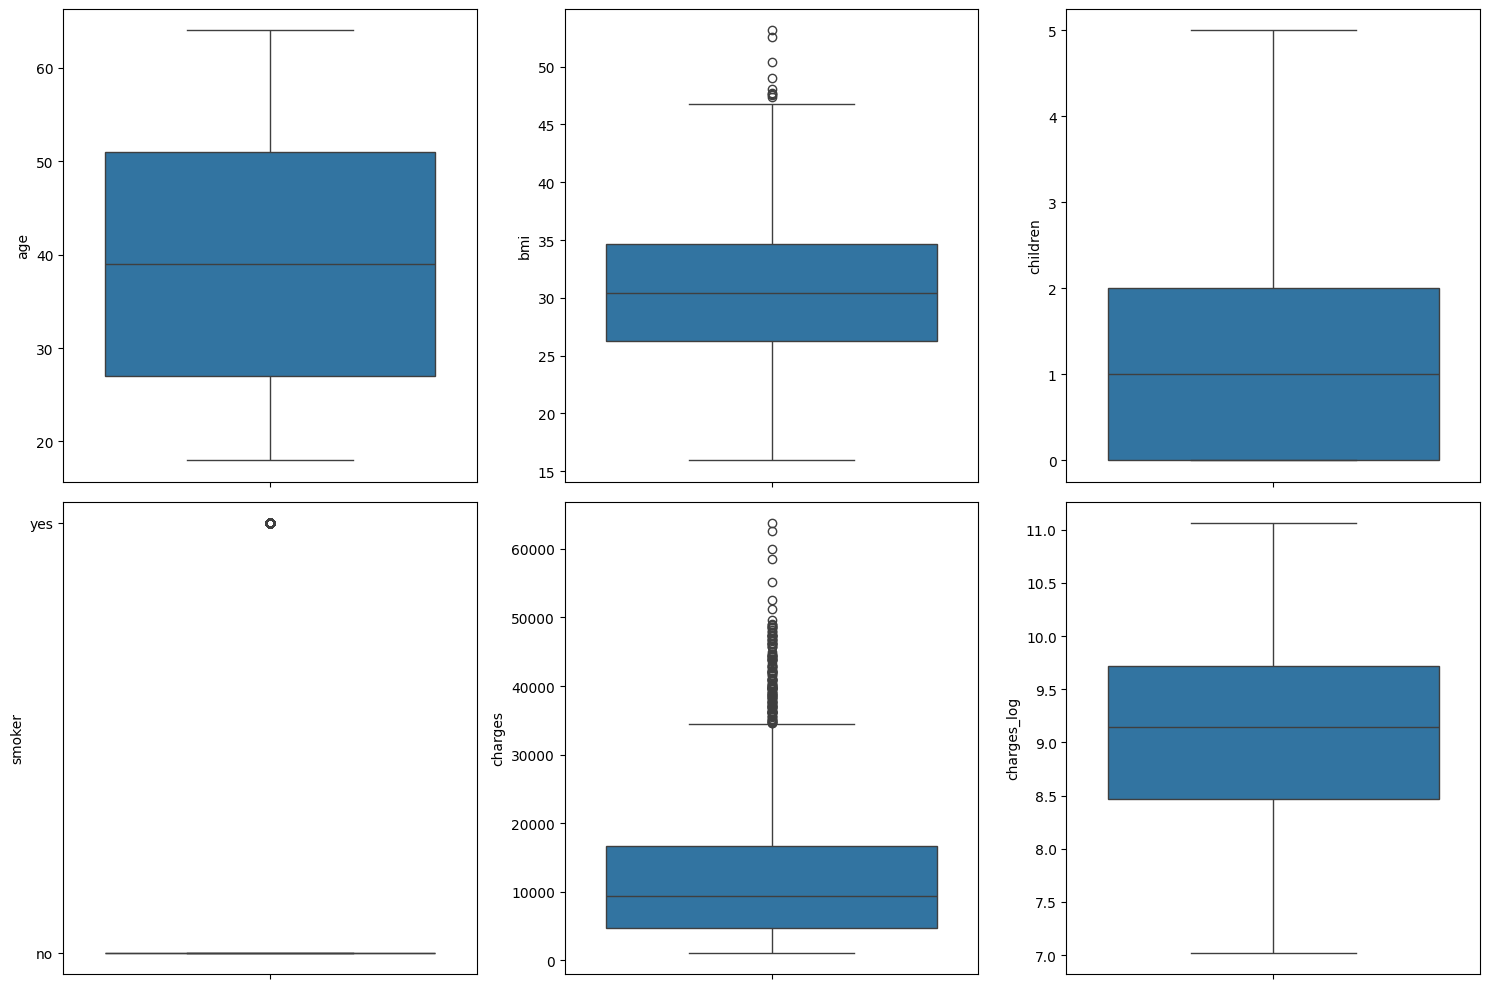

In [181]:
fig, axis = plt.subplots(2, 3, figsize = (15, 10))

sns.boxplot(ax = axis[0, 0], data = data, y = "age")
sns.boxplot(ax = axis[0, 1], data = data, y = "bmi")
sns.boxplot(ax = axis[0, 2], data = data, y = "children")
sns.boxplot(ax = axis[1, 0], data = data, y = "smoker")
sns.boxplot(ax = axis[1, 1], data = data, y = "charges")
sns.boxplot(ax = axis[1, 2], data = data, y = "charges_log")


plt.tight_layout()

plt.show()

In [182]:
data[['bmi', 'charges', 'charges_log']].describe()

,bmi,charges,charges_log
count,1337.000000,1337.000000,1337.000000
mean,30.663452,13279.121487,9.099928
std,6.100468,12110.359656,0.918699
min,15.960000,1121.873900,7.022756
25%,26.290000,4746.344000,8.465130
50%,30.400000,9386.161300,9.146992
75%,34.700000,16657.717450,9.720629
max,53.130000,63770.428010,11.063045


In [185]:
bmi_stats = data['bmi'].describe()

bmi_iqr = bmi_stats["75%"] - bmi_stats["25%"]
upper_limit = bmi_stats["75%"] + 1.5 * bmi_iqr
lower_limit = bmi_stats["25%"] - 1.5 * bmi_iqr

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(bmi_iqr, 2)}")

Los límites superior e inferior para la búsqueda de outliers son 47.32 y 13.67, con un rango intercuartílico de 8.41


In [189]:
total = (data['bmi'] > 47).sum()
print(f"{((data['bmi'] > 47).sum()) / len(data['bmi']) * 100}%")


0.6731488406881078%


In [191]:
data[data["bmi"] > 47]

# Podríamos eliminar los outlayers porque suponen un porcentaje muy pequeño, pero sumado al análisis univariante anterior,
# existe una implicación entre el precio del seguro y el índice de masa corporal, por lo que mantenemos los valores atípicos

,age,bmi,children,smoker,charges,smoker_num,charges_log
116,58,49.06,0,no,11381.32540,1,9.339729
286,46,48.07,2,no,9432.92530,1,9.151962
401,47,47.52,1,no,8083.91980,1,8.997632
543,54,47.41,0,yes,63770.42801,0,11.063045
846,23,50.38,1,no,2438.05520,1,7.798956
859,37,47.60,2,yes,46113.51100,0,10.738861
1046,22,52.58,1,yes,44501.39820,0,10.703276
1087,52,47.74,1,no,9748.91060,1,9.184911
1316,18,53.13,0,no,1163.46270,1,7.059156


In [ ]:
# Escalado de valores

escalar_variables = ["age", "bmi", "children", "sex_n", "smoker_n", "region_n", "charges"]